Bachelor thesis - Richard Borschke - 7337876 - University of Cologne - A spatio-temporal analysis of usage patterns in free-floating shared mobility


# Clustering Trip Types Based On Centrality And Duration

This notebook contains the identification of trip types. Following steps are performed:
* Feature selection
* Feature scaling via MinMaxScaler
* Clustering of trip types via k-means
* Evaluation of clustering (select k)
* Interpretation and visualization of cluster results
* Distribution of identified trip types among mobility modes

### Imports

In [1]:
import pandas as pd
import glob

import matplotlib.pyplot as plt
import seaborn as sns
#sns.set_theme(style="white")

from sklearn.preprocessing import MinMaxScaler


from sklearn.cluster import KMeans

from yellowbrick.cluster import KElbowVisualizer

import time
# import numpy as np

### Load Data

In [2]:
# load monthly data of mode based on selected months
def load_data(mode, months):
    first_read = True
    
    for month in months:
        data_month = pd.concat([pd.read_csv(file) for file in glob.glob('Data/Modes/data_supplemented_{}_{}.csv'.format(mode, month))], ignore_index = True)
        if (first_read):
            data_full = data_month
            first_read = False
        else:
            data_full = pd.concat([data_full, data_month], ignore_index=True)
    
    return data_full

# load full data of mode
def load_data_mode_full(mode):
    data_mode_full = pd.read_csv('Data/Modes/data_supplemented_full_{}.csv'.format(mode))
    
    return data_mode_full

In [3]:
# define months for data loading (YYYYMM)
months = ['201911', '201912', '202001', '202002']

#load data by months
load_monthly_data = False

if (load_monthly_data):
    data_car = load_data('car', months)
    data_bicycle = load_data('bicycle', months)
    data_scooter = load_data('scooter', months)
    data_full = pd.concat([data_car, data_bicycle, data_scooter], ignore_index=True)

In [4]:
# read in desired data
# set True if full data set load is desired
load_full_data = True

if (load_full_data):
    data_car = load_data_mode_full('car')
    data_bicycle = load_data_mode_full('bicycle')
    data_scooter = load_data_mode_full('scooter')
    data_full = pd.concat([data_car, data_bicycle, data_scooter], ignore_index=True)

### Feature selection

In [5]:
# select only dist features (based on manuelly defined trip types in literature) and id + vehicleType for later interpretation
#dfWARNING = data_full[['id','vehicleType','dist_center_start','dist_center_end']]
#df = dfWARNING.sample(n=100000, random_state=1)

df = data_full[['id','vehicleType','dist_center_start','dist_center_end', 'duration']].copy()
df['duration'] = df['duration'] / 60
df.columns

Index(['id', 'vehicleType', 'dist_center_start', 'dist_center_end',
       'duration'],
      dtype='object')

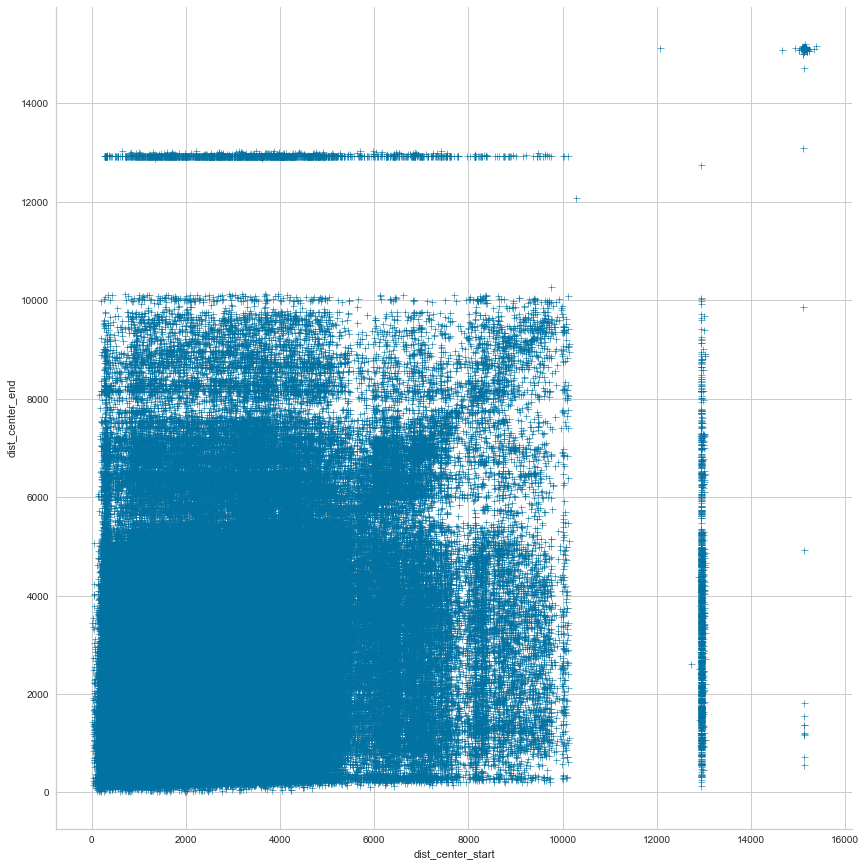

In [6]:
# plot features to visually observe structure of data
g = sns.relplot(x="dist_center_start", y="dist_center_end", kind="scatter", data=df, marker='+', height=12, aspect=1)

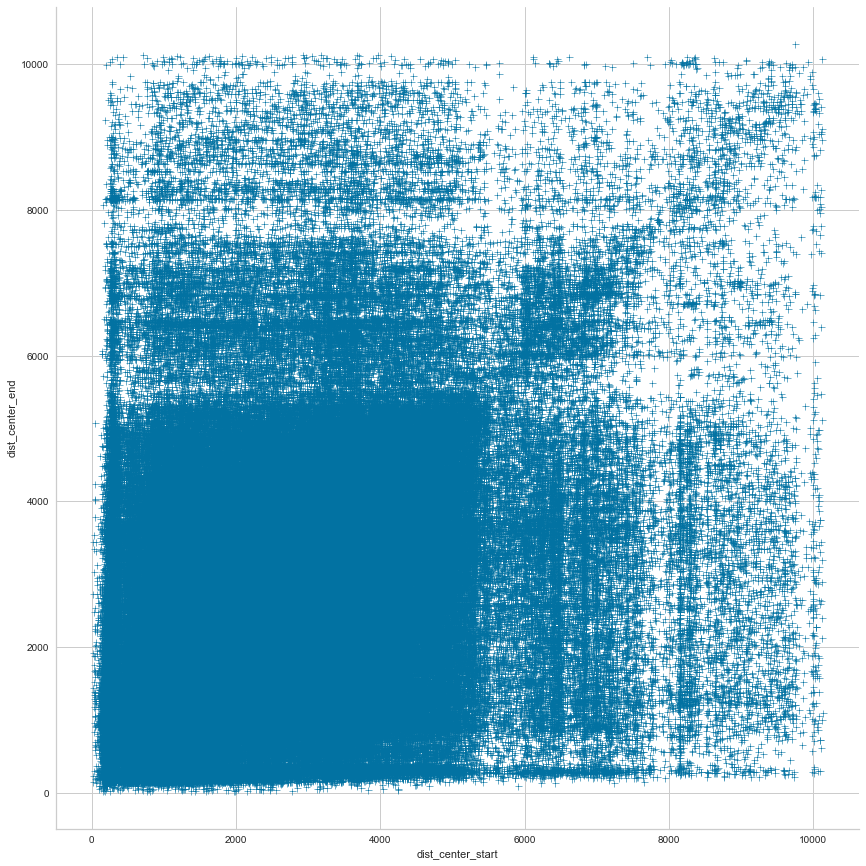

In [7]:
# remove extreme outliers
df = df[(df['dist_center_start']<11000)&(df['dist_center_end']<11000)]

# plot indicates four interpretable convex clusters
g = sns.relplot(x="dist_center_start", y="dist_center_end", kind="scatter", data=df, marker='+', height=12, aspect=1)

### Feature scaling

(array([0, 1, 2]),
 [Text(0, 0, 'dist_center_start'),
  Text(1, 0, 'dist_center_end'),
  Text(2, 0, 'duration')])

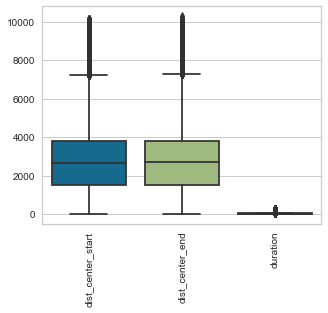

In [8]:
# look at feature skewness
plt.figure(figsize=(5,4))
sns.boxplot(data=df)
plt.xticks(rotation=90)

In [9]:
df_minmax = df[['dist_center_start','dist_center_end', 'duration']].copy()

# save names
names = df_minmax.columns

# scale data
scaler = MinMaxScaler()
scaler.fit(df_minmax)
df_minmax = scaler.transform(df_minmax)

# convert scaled array into dataframe
scaled_df = pd.DataFrame(df_minmax, columns=names) 

scaled_df

,dist_center_start,dist_center_end,duration
0,0.497973,0.464763,0.028911
1,0.046268,0.090555,0.071258
2,0.200791,0.467979,0.071258
3,0.289174,0.361439,0.092290
4,0.519031,0.261039,0.092290
...,...,...,...
401617,0.015917,0.035384,0.029263
401618,0.354325,0.407934,0.050506
401619,0.196639,0.305098,0.050506
401620,0.275136,0.286480,0.008160


(array([0, 1, 2]),
 [Text(0, 0, 'dist_center_start'),
  Text(1, 0, 'dist_center_end'),
  Text(2, 0, 'duration')])

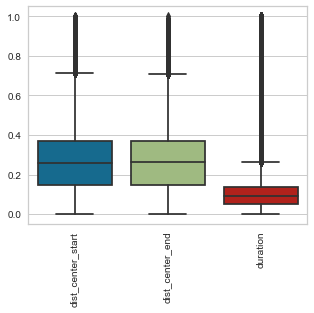

In [10]:
# visualize scaled features (still right skewed but scaled from 0 to 1 + 0 remains)
plt.figure(figsize=(5,4))
sns.boxplot(data=scaled_df)
plt.xticks(rotation=90)

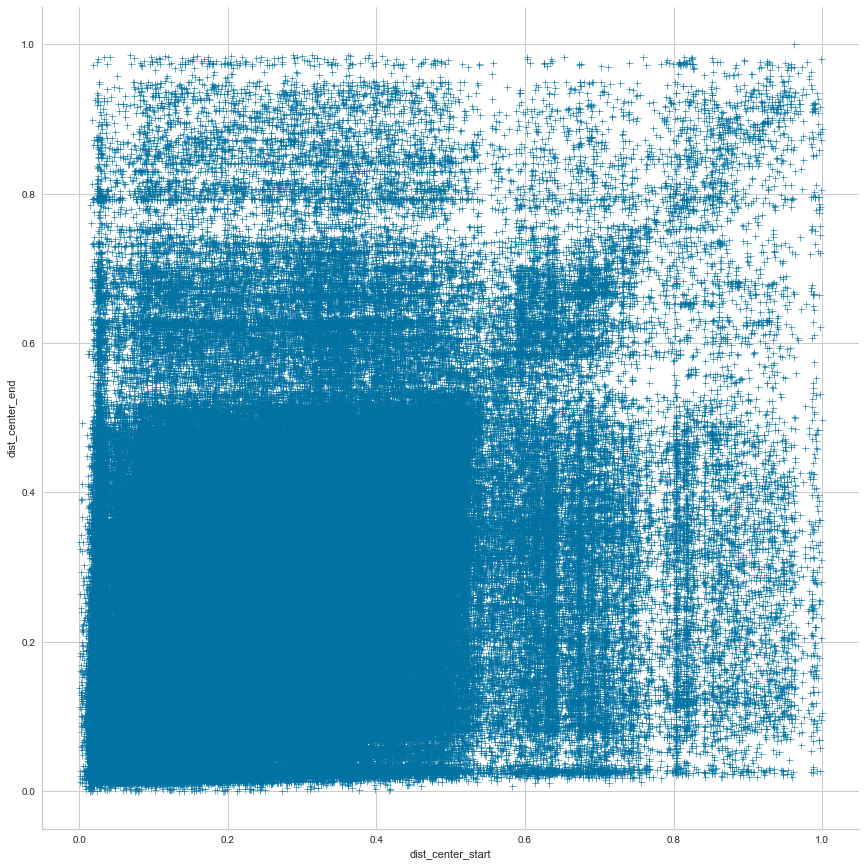

In [11]:
# plot still indicates four interpretable convex clusters
g = sns.relplot(x="dist_center_start", y="dist_center_end", kind="scatter", data=scaled_df, marker='+', height=12, aspect=1)

### Cluster Tendency

In [12]:
from pyclustertend import hopkins
hopkins(scaled_df, 10000)

0.08984544788126612

### Clustering trip types via k-means and parameter selection

In [13]:
# run k-means multiple times to identify "optimal" k

# with-in cluster sum of squares
wcss=[]

# run loop
for i in range (1,15):   
    start = time.time()
    kmeans = KMeans(i)
    kmeans.fit(scaled_df)
    wcss.append(kmeans.inertia_)
    end = time.time()
    print(i)
    print(end - start)

1
0.9250526428222656
2
3.3420631885528564
3
12.72055196762085
4
15.379457235336304
5
22.054031133651733
6
28.419127464294434
7
20.81696844100952
8
30.598710775375366
9
37.348822355270386
10
47.092750787734985
11
57.54717516899109
12
59.959227323532104
13
82.62664484977722
14
90.62050461769104


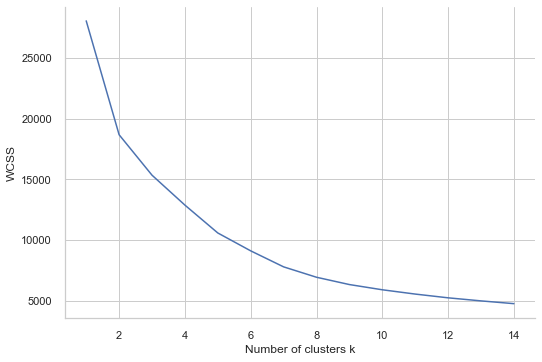

In [14]:
# plot elbow plot to visually pick "optimal" k
sns.set_theme(style="whitegrid")
g = sns.relplot(x=range(1,15), y=wcss, kind="line", height=5, aspect=1.5)
g.set_axis_labels('Number of clusters k', 'WCSS')

In [ ]:
# silhouette score EXTREMELY high running time
if (False):
    model = KMeans(random_state=0)

    # select range of cluster number and the metric to observe costs
    visualizer = KElbowVisualizer(model, k=(2,15), metric='silhouette', timings=False)

    # fit and visualize
    visualizer.fit(scaled_df)    
    visualizer.poof()

In [ ]:
# cluster data for the chosen number of clusters
k = 8
k_means_new = KMeans(k)

kmeans.fit(scaled_df)

clustered_data = df.copy()
clustered_data['cluster'] = k_means_new.fit_predict(scaled_df)

clustered_data

### Interpretation and visualization of results

* cluster: inner-inner trips
* cluster: outer-outer trips
* cluster: outer-inner trips
* cluster: inner-outer trips

In [ ]:
# show cluster results for interpretation
clustered_data.groupby(['cluster']).describe()

In [ ]:
# plot cluster results
g = sns.relplot(x="dist_center_start", y="dist_center_end", kind="scatter", data=clustered_data, marker='+', hue='cluster', palette='rainbow', height=12, aspect=1)

### Distribution of trip types among mobility modes

In [ ]:
# show cluster distribution
clustered_data.groupby(['vehicleType','cluster']).describe()

In [ ]:
def create_distribution_overview(mode):
    
    distribution = clustered_data[clustered_data['vehicleType']==mode]

    distribution = distribution.groupby(['cluster']).count().copy()
    trip_volume = len(clustered_data[clustered_data['vehicleType']==mode])
    distribution['Distribution [%]'] = distribution['id'] / trip_volume *100

    return distribution[['Distribution [%]']]

In [ ]:
create_distribution_overview('car')

In [ ]:
create_distribution_overview('bicycle')

In [ ]:
create_distribution_overview('scooter')